# Tutorial 1: Spatial CITE-seq (Human Tonsil)

DePass was applied to the human tonsil spatial CITE-seq dataset (2,492 spatial spots) for cross-modal integration and data enhancement. This tutorial demonstrates: 

1. Spatial domain identification in tonsil tissue using DePass.
2. Validation of data enhancement through comparative analysis of biomarker log2 fold-changes (LogFC) and spatial expression patterns.
3. In addition, simulate masked data and noisy data were constructed for DePass, demonstrating DePass's ability to recover biologically meaningful signals. 


### Preparation

In [ ]:
import scanpy as sc
import torch
import random
import pandas as pd
import numpy as np
import os
import warnings

warnings.filterwarnings("ignore")
from DePass.utils import *

import sys
# sys.path.append('/home/jyx/DePass/')

fix_seed(2024)  

# Environment configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

os.environ['R_HOME'] = '/home/jyx/anaconda3/envs/DePass/lib/R'
   
path = '../data/dataset_HumanTonsil'
os.mkdir(path) if not os.path.exists(path) else print(f"The directory '{path}' already exists.\n")

The directory '../data/dataset_HumanTonsil' already exists.



### Loading and preprocessing

Load the raw count data and perform preprocessing to ensure high-quality input for model. The preprocessing methods are detailed below:
For transcriptomics, we filtered gene features to retain those detected in ≥1% of cells. Top 1,000 highly variable genes (HVGs) were selected via Seurat v3 dispersion-based method. Counts were normalized per cell (total scaling to 10^4), followed by log1p transformation and z-score standardization via scanpy package. For proteomics, protein expression matrices were normalized using centered log-ratio (CLR) transformation to address compositionality biases, followed by feature-wise z-score standardization.

In [ ]:
adata_omics1 = sc.read_h5ad('../data/dataset_HumanTonsil/adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad('../data/dataset_HumanTonsil/adata_ADT.h5ad')

preprocess_data(adata=adata_omics1,modality='rna')
preprocess_data(adata=adata_omics2,modality='protein')

adata_omics1.obsm['input_feat'] = adata_omics1.obsm['X_norm'].copy()
adata_omics2.obsm['input_feat'] = adata_omics2.obsm['X_clr'].copy()
data = {'rna': adata_omics1, 'protein': adata_omics2}


### Training the model

The DePass model is designed for multi-omics data integration at both spatial and single-cell data. After training, the output file includes the following key results:

1. **`embedding`**: Integrated embedding representation, which integrates multi-omics expression features with spatial coordinate information (for spatial data). This representation is used directly for downstream tasks (e.g., spatial domain segmentation) or visualization (e.g., UMAP). 
2. **`x1_enh`**: Enhanced feature matrix for the first omics modality.  
3. **`x2_enh`**: Enhanced feature matrix for the second omics modality.  
4. **`alpha`**: Cross-modality attention weight matrix, dynamically learned through a attention mechanism. It reflects the relative importance of each modality in clustering units (e.g., cells/spots/bins).

In [ ]:
from DePass.model import DePass
# data (dict): Input data dictionary containing multiple modality data. 
# data_type (str, optional): Data type, which can be 'spatial' or 'single_cell'.  
# epochs (int, optional): Total number of training epochs. Defaults to 200. 
# batch_training (bool, optional): Whether to use batch training. Defaults to False. 
model = DePass(data, data_type='spatial',device=device)
output = model.train()

[Config]
Modalities: 2 | Data: spatial | Device: NVIDIA GeForce RTX 4090 

[Initializing]
Graph Construction : Running...
Graph Construction : Done!
Data Enhancement : Running...
Data Enhancement : Done!

[Training]
Model training starts...


100%|██████████| 200/200 [00:02<00:00, 70.81it/s]

Model training finished!



In [ ]:
adata = adata_omics1.copy()
adata.obsm['DePass'] = model.embedding
adata.obsm['alpha'] = model.alpha 
adata.obsm['x1_enh'] = model.x1_enh
adata.obsm['x2_enh'] = model.x2_enh

### Detect spatial domain 

After the model is trained, we use the integrated representation for cluster analysis. Here we provide three optional clustering tools, including **mclust**, **leiden**, and **kmeans**. We recommend using the **mclust** algorithm for clustering and specifying the number of target clusters. In this example, we set the number of clusters to 7 and use PCA for dimensionality reduction by setting `use_pca=True`.  The clustering results are stored in the `adata` object under the key `'DePass'`. 

We perform spatial visualization of regions using matplotlib, where colors correspond to the cluster assignments. 


In [ ]:
from DePass.utils import *
clustering(adata=adata,n_clusters=7,key='DePass',add_key='DePass',method='mclust',use_pca=True)


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


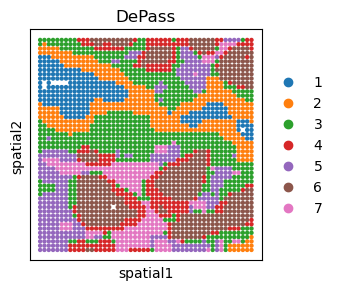

In [ ]:
from DePass.analyze_utils import plot_spatial

plot_spatial(
    adata,
    color='DePass',
    save_path=path,
    save_name='DePass',
    title="DePass",
    s=40,
    show=True,
)


In [ ]:
adata.write(path+'/adata.h5ad')

### Visualization of the attention weights
The attention mechanism dynamically learns weights across all modalities for each individual cell (spots/bins). These weights reveal relative importance of different modalities (transcriptomics, proteomics). High proteomics weights within a cluster indicate that proteomic data significantly drives the molecular characterization of that cluster.

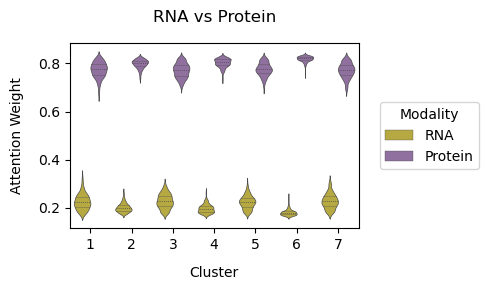

<Axes: title={'center': 'RNA vs Protein'}, xlabel='Cluster', ylabel='Attention Weight'>

In [ ]:
from DePass.analyze_utils import plot_modality_weights
plot_modality_weights(
    adata,
    save_path=path,
    save_name="rna_protein_weights",
)

### Data enhancement analysis


Perform differential expression analysis using **scanpy**. Set the grouping variable to 'DePass'. Rank genes with the 'wilcoxon' method to calculate log-fold change (logFC) values. 



In [ ]:
import anndata as ad
# Create two AnnData objects to store the raw and enhanced data. 
adata2_R = ad.AnnData(X=adata_omics2.obsm['X_clr'], obs=adata.obs[['DePass']].copy(), var=adata_omics2.var.copy(), obsm={'spatial': adata_omics2.obsm['spatial'].copy()})
adata2_E = ad.AnnData(X=adata.obsm['x2_enh'], obs=adata.obs[['DePass']].copy(), var=adata_omics2.var.copy(), obsm={'spatial': adata_omics2.obsm['spatial'].copy()})


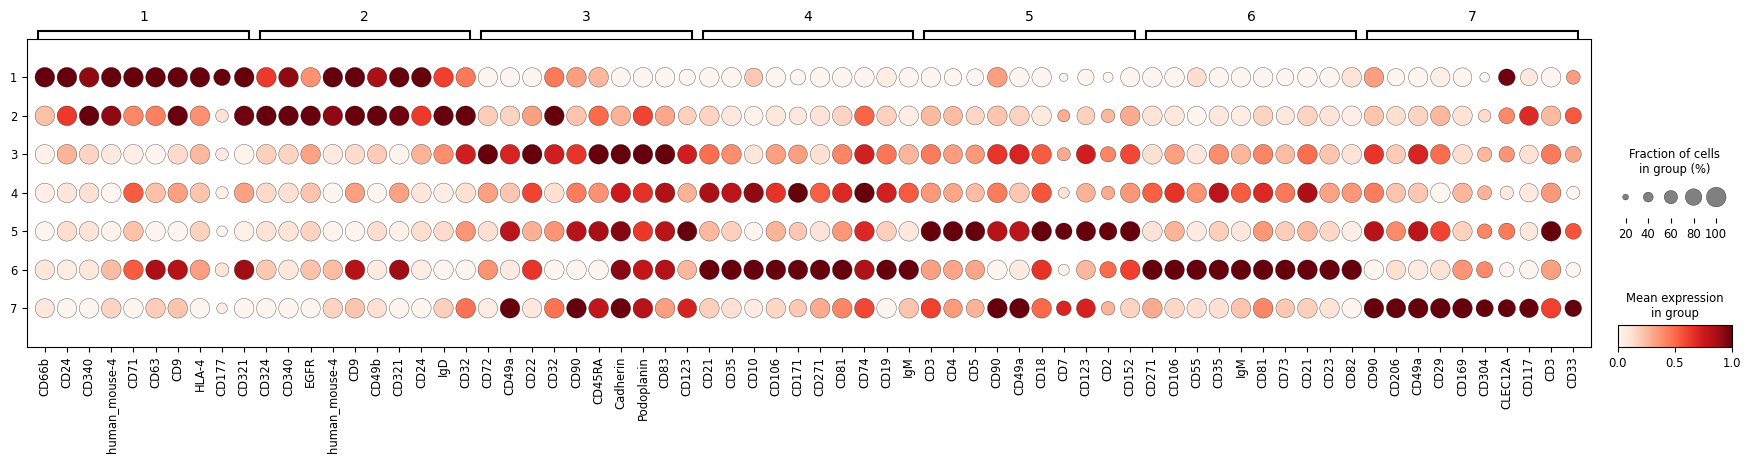

In [ ]:
from DePass.analyze_utils import rank_genes_groups
rank_genes_groups(adata=adata2_R, save_path=path, groupby='DePass', figname='rank_x2_R',figsize=(22,4),  n_genes=10,show=True)
rank_genes_groups(adata=adata2_E, save_path=path, groupby='DePass', figname='rank_x2_E',figsize=(22,4),  n_genes=10,show=False)

We use the function `plot_marker_comparison_with_logFC` to visualize the spatial expression patterns and logFC (log fold-change) for markers.

To use this function, the user must specify the **target gene** and its corresponding **cluster/group**. If analyzing the gene `CD23` in **group 6**, set:

- target_gene = "CD23",

- target_group = "6"

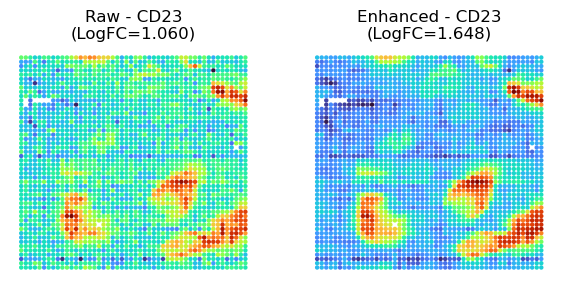

In [ ]:
from DePass.analyze_utils import plot_marker_comparison_with_logFC

plot_marker_comparison_with_logFC(adata2_R, adata2_E, target_gene='CD23', target_group='6',save_path=path, save_name='CD23', s=40, show=True)

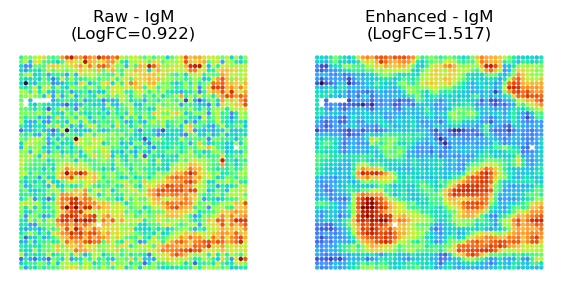

In [ ]:
from DePass.analyze_utils import plot_marker_comparison_with_logFC

plot_marker_comparison_with_logFC(adata2_R, adata2_E, target_gene='IgM', target_group='6',save_path=path, save_name='IgM', s=40, show=True)

### DePass for noisy data

To assess the robustness of DePass under noisy conditions, we introduced noise and random masking to simulate data corruption. Specifically, we added zero-mean Gaussian noise with a standard deviation of 1.5 to both RNA and protein data during preprocessing, prior to model input.

In [ ]:
def noise(adata1, adata2, noise_level=1.5):
    from scipy import stats
    noise1 = stats.norm.rvs(loc=0, scale=noise_level, size=adata1.shape)
    noise2 = stats.norm.rvs(loc=0, scale=noise_level, size=adata2.shape)
    return adata1 + noise1, adata2 + noise2

noisy_data1, noisy_data2 = noise(adata_omics1.obsm['X_norm'],adata_omics2.obsm['X_clr'])


In [ ]:
adata_omics1.obsm['input_feat'] = noisy_data1
adata_omics2.obsm['input_feat'] = noisy_data2
data = {'rna': adata_omics1, 'protein': adata_omics2}

model_N = DePass(data, data_type='spatial',device=device)  
model_N.train()

adata.obsm['DePass_noise'] = model_N.embedding
adata.obsm['x2_enh_noise'] = model_N.x2_enh

import anndata as ad
# Create two AnnData objects to store the noisy and enhanced noisy data. 
adata2_R_noise = ad.AnnData(X=noisy_data2, obs=adata.obs[['DePass']].copy(), var=adata_omics2.var.copy(), obsm={'spatial': adata_omics2.obsm['spatial'].copy()})
adata2_E_noise = ad.AnnData(X=adata.obsm['x2_enh_noise'], obs=adata.obs[['DePass']].copy(), var=adata_omics2.var.copy(), obsm={'spatial': adata_omics2.obsm['spatial'].copy()})

[Config]
Modalities: 2 | Data: spatial | Device: NVIDIA GeForce RTX 4090 

[Initializing]
Graph Construction : Running...
Graph Construction : Done!
Data Enhancement : Running...
Data Enhancement : Done!

[Training]
Model training starts...


100%|██████████| 200/200 [00:01<00:00, 104.04it/s]

Model training finished!



### DePass for maskded data 

Random masking was implemented through modality-specific protocols: For RNA data, non-zero entries were randomly masked following HVG selection. Protein data were masked prior to CLR normalization. 

In [ ]:
adata1_raw=sc.read_h5ad('../data/dataset_HumanTonsil/adata_RNA.h5ad')
adata2_raw=sc.read_h5ad('../data/dataset_HumanTonsil/adata_ADT.h5ad')

def Generate_masked_data(adata_omics1,adata_omics2,mask_ratio):
    from scipy import sparse
    from DePass.utils import preprocess_data

    adata_omics1.var_names_make_unique()
    adata_omics2.var_names_make_unique()

    def mask(adata, ratio):
        X = adata.X.copy()  
        if sparse.issparse(X):
            nonzero_positions = X.nonzero()
        else:
            nonzero_positions = np.nonzero(X)

        num_to_mask = int(ratio * len(nonzero_positions[0]))
        mask_indices = np.random.choice(len(nonzero_positions[0]), num_to_mask, replace=False)
        
        if sparse.issparse(X):
            X[(nonzero_positions[0][mask_indices], nonzero_positions[1][mask_indices])] = 0
        else:
            X[nonzero_positions[0][mask_indices], nonzero_positions[1][mask_indices]] = 0
        adata.X = X
        return adata

    sc.pp.filter_genes(adata_omics1, min_cells=adata_omics1.shape[0] * 0.01)
    sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=1000)
    adata_omics1 = adata_omics1[:, adata_omics1.var['highly_variable']]
    adata_omics1 = mask(adata_omics1, mask_ratio)
    sc.pp.normalize_total(adata_omics1, target_sum=1e4)
    sc.pp.log1p(adata_omics1)
    sc.pp.scale(adata_omics1)

    adata_omics2 = mask(adata_omics2, mask_ratio)
    preprocess_data(adata_omics2, modality='protein')
    return adata_omics1.X, adata_omics2.X

masked_data1, masked_data2 = Generate_masked_data(adata1_raw,adata2_raw,mask_ratio=0.16)

adata_omics1.obsm['input_feat'] = masked_data1
adata_omics2.obsm['input_feat'] = masked_data2
data = {'rna': adata_omics1, 'protein': adata_omics2}

In [ ]:
model_M = DePass(data, data_type='spatial',device=device)  
model_M.train()

adata.obsm['DePass_mask'] = model_M.embedding
adata.obsm['x2_enh_mask'] = model_M.x2_enh

import anndata as ad
# Create two AnnData objects to store the masked and enhanced masked data. 
adata2_R_mask = ad.AnnData(X=masked_data2, obs=adata.obs[['DePass']].copy(), var=adata_omics2.var.copy(), obsm={'spatial': adata_omics2.obsm['spatial'].copy()})
adata2_E_mask = ad.AnnData(X=adata.obsm['x2_enh_mask'], obs=adata.obs[['DePass']].copy(), var=adata_omics2.var.copy(), obsm={'spatial': adata_omics2.obsm['spatial'].copy()})

[Config]
Modalities: 2 | Data: spatial | Device: NVIDIA GeForce RTX 4090 

[Initializing]
Graph Construction : Running...
Graph Construction : Done!
Data Enhancement : Running...
Data Enhancement : Done!

[Training]
Model training starts...


100%|██████████| 200/200 [00:01<00:00, 100.22it/s]

Model training finished!



### Data enhancement analysis: clustering

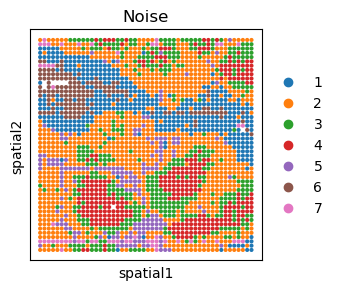

In [ ]:
from DePass.utils import *
clustering(adata=adata2_R_noise,n_clusters=7,use_X=True,add_key='noise',method='mclust',use_pca=True)

from DePass.analyze_utils import *
plot_spatial(
    adata2_R_noise,
    color='noise',
    save_path=path,
    title="Noise",
    save_name="Noise",
    s=40,
    show=True,
)

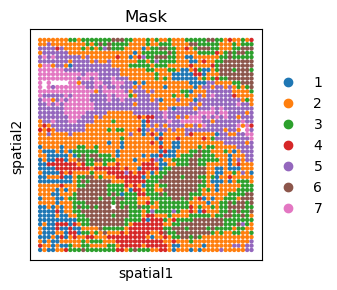

In [ ]:
from DePass.utils import *
clustering(adata=adata2_R_mask,n_clusters=7,use_X=True,add_key='mask',method='mclust',use_pca=True)
plot_spatial(
    adata2_R_mask,
    color='mask',
    save_path=path,
    title="Mask",
    save_name="Mask",
    s=40,
    show=True,
)

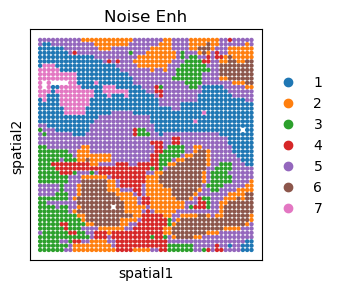

In [ ]:
from DePass.utils import *
clustering(adata=adata2_E_noise,n_clusters=7,use_X=True,add_key='noise enh',method='mclust',use_pca=True)

plot_spatial(
    adata2_E_noise,
    color='noise enh',
    save_path=path,
    title="Noise Enh",
    save_name="Noise Enh",
    s=40,
    show=True
)


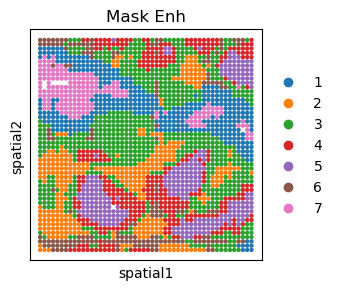

In [ ]:
from DePass.utils import *
clustering(adata=adata2_E_mask,n_clusters=7,use_X=True,add_key='mask enh',method='mclust',use_pca=True)

plot_spatial(
    adata2_E_mask,
    color='mask enh',
    save_path=path,
    title="Mask Enh",
    save_name='Mask Enh',
    s=40,
    show=True,
)


In [ ]:
adata2_R_noise.write(path+'/adata2_R_noise.h5ad')
adata2_E_noise.write(path+'/adata2_E_noise.h5ad')
adata2_R_mask.write(path+'/adata2_R_mask.h5ad')
adata2_E_mask.write(path+'/adata2_E_mask.h5ad')

### Data enhancement analysis: marker LogFC and expression pattern


Perform differential expression analysis using **scanpy**. Set the grouping variable to 'DePass'. Rank genes with the 'wilcoxon' method to calculate logFC values. 



In [ ]:
from DePass.analyze_utils import rank_genes_groups
rank_genes_groups(adata=adata2_R_noise, groupby='DePass', method='wilcoxon', n_genes=10,show=False)
rank_genes_groups(adata=adata2_E_noise, groupby='DePass', method='wilcoxon', n_genes=10,show=False)
rank_genes_groups(adata=adata2_R_mask , groupby='DePass', method='wilcoxon', n_genes=10,show=False)
rank_genes_groups(adata=adata2_E_mask , groupby='DePass', method='wilcoxon', n_genes=10,show=False)

We use the function `plot_marker_comparison_with_logFC` to visualize the spatial expression patterns and logFC for markers.

To use this function, the user must specify the **target gene** and its corresponding **cluster/group**. If analyzing the gene `CD23` in **group 6**, set:

- target_gene = "CD23",

- target_group = "6"

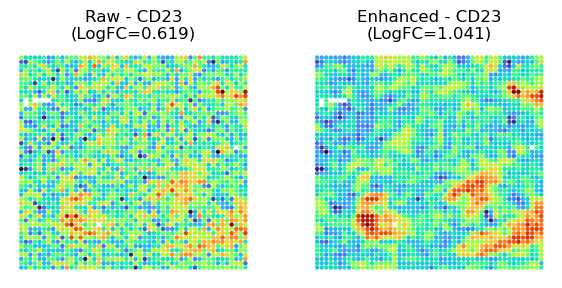

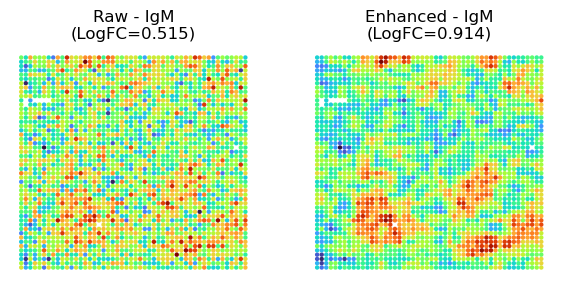

In [ ]:
from DePass.analyze_utils import plot_marker_comparison_with_logFC

plot_marker_comparison_with_logFC(adata2_R_noise, adata2_E_noise, target_gene='CD23', target_group='6', save_path=path, save_name='CD23', s=40,show=True)
plot_marker_comparison_with_logFC(adata2_R_noise, adata2_E_noise, target_gene='IgM', target_group='6', save_path=path, save_name='IgM', s=40, show=True)

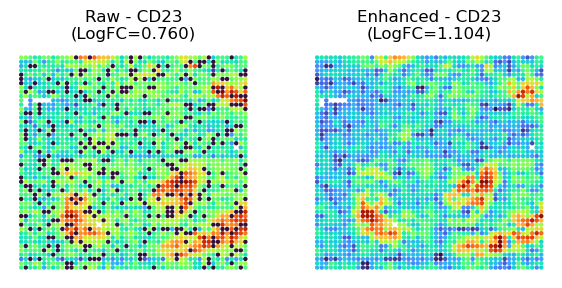

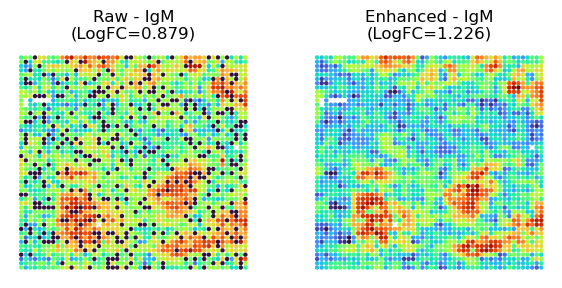

In [ ]:
plot_marker_comparison_with_logFC(adata2_R_mask, adata2_E_mask, target_gene='CD23', target_group='6', save_path=path, save_name='CD23', s=40, show=True)
plot_marker_comparison_with_logFC(adata2_R_mask, adata2_E_mask, target_gene='IgM', target_group='6', save_path=path, save_name='IgM', s=40, show=True)

### LogFC comparison

In [ ]:

MASK = "M"
MASK_ENH = "M+"
NOISE = "N"
NOISE_ENH = "N+" 
RAW = "R"
RAW_ENH = "R+"

name=[MASK, MASK_ENH,NOISE, NOISE_ENH, RAW, RAW_ENH]


target_genes = ['CD23', 'IgM','CD21','CD171','CD35','CD3', 'CD4','CD5'] 
target_groups = ['6']*5 +  ['5']*3  # The user needs to specify the clustering corresponding to each marker. 

from DePass.analyze_utils import get_logfc_df
long_df = get_logfc_df(
    adata_list=[adata2_R_mask, adata2_E_mask,adata2_R_noise, adata2_E_noise, adata2_R, adata2_E],
    adata_names=name,
    target_genes=target_genes,
    target_groups=target_groups,
    save_path=path,
    save_name="marker_logfc_comparison"
)

long_df.to_csv(path+'/df_logFC.csv',sep='\t')     

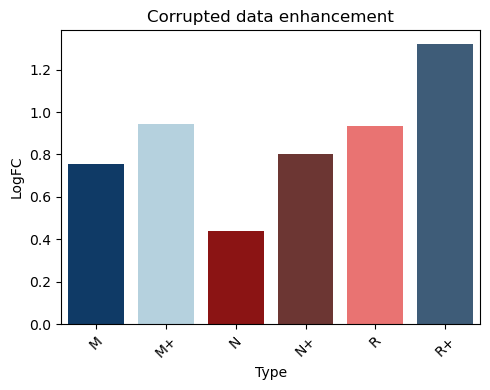

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

hue_order = name
custom_palette = [ "#003A75", "#AED4E5","#9F0000",'#762E29','#FD5F5E','#345D82']

plt.figure(figsize=(5, 4))

sns.barplot(
    data=long_df,
    x='type',
    y='logFC',
    ci=None,
    palette=custom_palette, 
    hue_order=hue_order,
)

plt.title('Corrupted data enhancement')
plt.xlabel('Type')
plt.ylabel('LogFC')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(path + '/marker_enh_all.png',dpi=300)